In [1]:
import pandas as pd
import re
from sklearn.model_selection import train_test_split
import re
import unicodedata
import html

In [2]:
#pip install seaborn

In [3]:
df = pd.read_csv('./reddit_filtered_submissions_balanced_score10.csv')
df.head()

,label,text,date,text_length
0,adhd,"Ever tell yourself, “you gotta do *thing you’r...",2020-01-11,671
1,adhd,"13 years and 5 dropouts later, I FINALLY GRADU...",2020-01-02,310
2,adhd,Lol bless this subreddit: Has anyone noticed h...,2020-01-07,172
3,adhd,"Just diagnosed at 27, and I'm mad.: At 27 year...",2020-01-28,1397
4,adhd,Having ADHD is like all thoughts are based on ...,2020-01-01,1176


In [4]:
def preprocess_text(text, label=None, lowercase=True):
    if not text:
        return ""
    # Convert to string and handle potential None values
    text = str(text) if text is not None else ""
    # Decode HTML entities
    text = html.unescape(text)
    # Normalize Unicode characters
    text = unicodedata.normalize('NFKD', text)
    # Mental health term handling with more comprehensive replacements
    if label:
        # More comprehensive and sensitive replacements
        replacements = {
            "adhd": "attention difficulty",
            "anxiety": "worry",
            "bipolar": "mood fluctuation",
            "bpd": "emotional regulation difficulty",
            "depression": "low mood",
            "ocd": "repetitive behavior",
            "ptsd": "stress response",
        }
        # Only replace if it's a standalone word (not part of another word)
        if label.lower() in replacements:
            pattern = r'\b' + re.escape(label.lower()) + r'\b'
            text = re.sub(pattern, replacements[label.lower()], text, flags=re.IGNORECASE)
    # Enhanced text cleaning with better regex patterns
    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    # Remove mentions more comprehensively
    text = re.sub(r'@\w+', '', text)
    # Remove emails more comprehensively
    text = re.sub(r'\b[\w.%+-]+@[\w.-]+\.[a-zA-Z]{2,}\b', '', text)
    # Remove phone numbers (various formats)
    text = re.sub(r'\b(\+\d{1,2}\s?)?\(?\d{3}\)?[\s.-]?\d{3}[\s.-]?\d{4}\b', '', text)
    # Remove addresses more comprehensively
    address_pattern = r'\b\d+\s+[\w\s]*(street|st|avenue|ave|road|rd|boulevard|blvd|lane|ln|drive|dr|court|ct|plaza|plz|square|sq|highway|hwy|parkway|pkwy|circle|cir|way)\b'
    text = re.sub(address_pattern, '', text, flags=re.IGNORECASE)
    # Optionally keep some punctuation for sentiment analysis
    text = re.sub(r'[^\w\s.,!?]', '', text)
    # Normalize whitespace (consecutive spaces, tabs, newlines)
    text = re.sub(r'\s+', ' ', text).strip()
    # Lowercase the text if specified
    if lowercase:
        text = text.lower()
    return text

In [5]:
# Load and preprocess data
print("Loading and preprocessing data...")
df["processed_text"] = [preprocess_text(row["text"], row["label"]) for _, row in df.iterrows()]
label_map = {"adhd": 0, "anxiety": 1, "bipolar": 2, "bpd": 3, "depression": 4, "ocd": 5, "ptsd": 6, "none": 7}
df["label_id"] = df["label"].map(label_map)

train_df, val_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df['label_id'])
print(f"Data split - Training samples: {len(train_df)}, Validation samples: {len(val_df)}")

Loading and preprocessing data...
Data split - Training samples: 21261, Validation samples: 9113


In [6]:
# Reset indices for both dataframes
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

### Train Dataframe

In [7]:
train_df = train_df[["processed_text", "label", "label_id"]]
train_df.head()

,processed_text,label,label_id
0,can someone talk to me? i literally just need ...,anxiety,1
1,reframing the narrative in my mind its so anno...,bpd,3
2,repetitive behavior is a label. do not let it ...,ocd,5
3,someone help right now the weirdest thing just...,bpd,3
4,dae feel hurt when people say that happens to ...,bpd,3


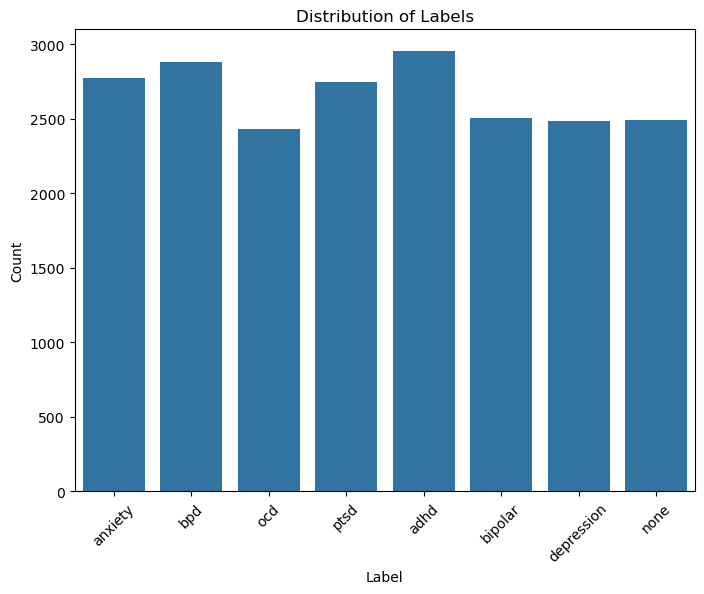

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=train_df)
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate x-axis labels if there are many unique labels
plt.show()

### Test Dataset

In [9]:
val_df = val_df[["processed_text", "label", "label_id"]]
val_df.head()

,processed_text,label,label_id
0,do intrusive thoughts include cringey memories...,ocd,5
1,you got no reason to be depressed no. please d...,depression,4
2,today i became a doctor i finished med school ...,adhd,0
3,when you realize just how different normal lif...,ptsd,6
4,do you find yourself forgetting things when tr...,ptsd,6


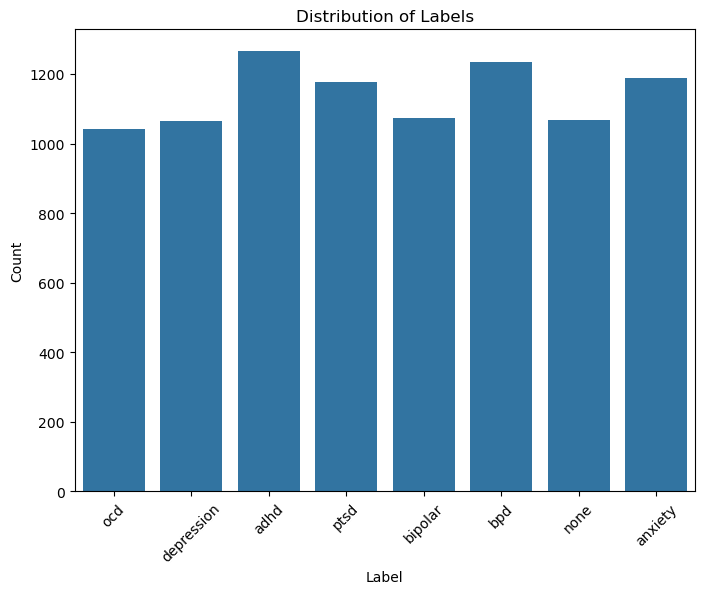

In [10]:
plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=val_df)
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate x-axis labels if there are many unique labels
plt.show()

### Save to csv

In [11]:
train_df.to_csv('./train_dataset.csv', index=False)
val_df.to_csv('./val_dataset.csv', index=False)